# Import Statements

In [2]:
import networkx as nx
import os
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from prettytable import PrettyTable

sns.set()
%matplotlib inline

In [59]:
import pylab
import community

In [4]:
dataset_path = os.path.join(os.getcwd(), r"..\datasets")
print(dataset_path)

C:\Project_Files\VT\SecondSem\SMA\Project\Notebooks\..\datasets


In [5]:
os.listdir(dataset_path)

['amazon-meta.txt',
 'amazon-meta.txt.gz',
 'amazon0302.txt',
 'amazon0302.txt.gz',
 'com-amazon.all.dedup.cmty.txt',
 'com-amazon.all.dedup.cmty.txt.gz',
 'com-amazon.top5000.cmty.txt',
 'com-amazon.top5000.cmty.txt.gz',
 'com-amazon.ungraph.txt',
 'com-amazon.ungraph.txt.gz',
 'test.csv']

In [6]:
# prod_path = os.path.join(dataset_path, "amazon-meta.txt", "products_data.csv")
# prod_graph_path = os.path.join(dataset_path, "amazon-meta.txt", "products_copurchases_links.csv")

In [5]:
prod_path = os.path.join(dataset_path, "products_data.csv")
prod_graph_path = os.path.join(dataset_path, "products_copurchases_links.csv")

In [8]:
prod_df = pd.read_csv(prod_path, encoding = 'unicode_escape')
prod_df.head(5)

,id,title,group,salesrank,review_cnt,downloads,rating
0,1,Patterns of Preaching: A Sermon Sampler,Book,396585,2,2,5.0
1,2,Candlemas: Feast of Flames,Book,168596,12,12,4.5
2,3,World War II Allied Fighter Planes Trading Cards,Book,1270652,1,1,5.0
3,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,631289,1,1,4.0
4,5,Prayers That Avail Much for Business: Executive,Book,455160,0,0,0.0


In [9]:
network_df = pd.read_csv(prod_graph_path, encoding = 'unicode_escape')
network_df.head(5)

,source,destination
0,1,161555
1,1,244916
2,1,118052
3,1,444232
4,1,500600


# Dataset information and stats

In [10]:
prod_df.shape

(542682, 7)

The various products in the dataset.

In [11]:
prod_df["group"].unique()

array(['Book', 'Music', 'DVD', 'Video', 'Toy', 'Software', 'Baby', 'CE',
       'Sports', 'A'], dtype=object)

In [12]:
prod_df["group"].value_counts()

Book        393559
Music       103143
Video        26132
DVD          19828
Toy              8
Software         5
CE               4
Baby             1
Sports           1
A                1
Name: group, dtype: int64

Among the various products, Books, Music and Video are the predominant categories.

In [14]:
prod_df[prod_df["salesrank"]==-1]

,id,title,group,salesrank,review_cnt,downloads,rating
688,693,Labour and Locality: Uneven Development and th...,Book,-1,0,0,0.0
1709,1727,Vehicular Technology 51st Conference Proceedings,Book,-1,0,0,0.0
1817,1837,Uncovered,Music,-1,0,0,0.0
2596,2617,DIMENSIONS OF FAITH,Book,-1,0,0,0.0
2972,2996,Fracture Mechanics,Book,-1,0,0,0.0
...,...,...,...,...,...,...,...
505981,511781,Mapping the Renaissance World,Book,-1,0,0,0.0
510064,515906,Love Existence,Music,-1,0,0,0.0
518459,524308,Pussy King of the Pirates,Music,-1,7,7,3.5
527011,532869,Napa County Wineries,Book,-1,3,3,5.0


Many products have sales rank -1, which don't contribute much info. hence dropping them

In [15]:
prod_df = prod_df[prod_df["salesrank"] != -1]

In [16]:
prod_df["salesrank"].min(), prod_df["salesrank"].max()

(0, 3798351)

The salesrank is way to high. Hence taking those products with sales rank under 100000

In [17]:
SALESRANK_TOP = 100000

books_df = prod_df[
    (prod_df["group"] == "Book") &
    (prod_df["salesrank"] <= SALESRANK_TOP)
]

In [18]:
books_df.shape

(51711, 7)

In [19]:
books_df.rating.min(), books_df.rating.max()

(0.0, 5.0)

In [20]:
books_df.rating.value_counts()

4.5    15857
5.0    14537
4.0    10461
3.5     4250
0.0     4063
3.0     1725
2.5      452
2.0      228
1.0       87
1.5       51
Name: rating, dtype: int64

Majority of the books got a rating of 4.5

In [21]:
network_df.columns

Index(['source', 'destination'], dtype='object')

In [22]:
# obtaining the respective nodes related to the group Book
network_books_df = network_df[
    network_df.source.isin(books_df.id) & 
    network_df.destination.isin(books_df.id)
]

In [23]:
network_books_df.shape

(123704, 2)

So there are almost 123k edges to workupon.

In [25]:
# obtaining the in_degree of the graph
network_book_indegree = network_books_df.groupby(['destination'])['source'].size().reset_index(name='in_degree')


In [24]:
# obtaining the out_degree of the graph
network_book_outdegree = network_books_df.groupby(['source'])['destination'].size().reset_index(name='out_degree')

In [27]:
network_book_indegree["in_degree"].min(), network_book_indegree["in_degree"].max()

(1, 82)

Minimum in_degree is 1 and Maximum in_degree is 82

In [28]:
network_book_outdegree["out_degree"].min(), network_book_outdegree["out_degree"].max()

(1, 5)

Minimum out_degree is 1 and Maximum out_degree is 5

In [29]:
# Top 5 product information
temp_1 = network_book_outdegree.set_index('source')
temp_2 = network_book_indegree.set_index('destination').rename_axis('source')
temp_2.columns = temp_1.columns

merged = temp_2.add(temp_1, fill_value=0).loc[temp_2.index, :].reset_index()

In [30]:
merged.nlargest(5, 'out_degree')

,source,out_degree
11942,199628,87.0
27521,458358,74.0
30207,502784,74.0
25934,430936,62.0
5926,98756,61.0


In [53]:
for row in merged.nlargest(5, 'out_degree').iterrows():
    # print(row[1].source)
    title = prod_df[prod_df['id'] == int(row[1].source)]
    print(f"Title: {title.iat[0,1]}")
    print(f"Outdegree: {row[1].out_degree}")
    print("#-----------------------------")

Title: The Great Gatsby
Outdegree: 87.0
#-----------------------------
Title: Diagnostic and Statistical Manual of Mental Disorders DSM-IV-TR
Outdegree: 74.0
#-----------------------------
Title: Brown Bear  Brown Bear  What Do You See?
Outdegree: 74.0
#-----------------------------
Title: Fireflies
Outdegree: 62.0
#-----------------------------
Title: The Catcher in the Rye
Outdegree: 61.0
#-----------------------------


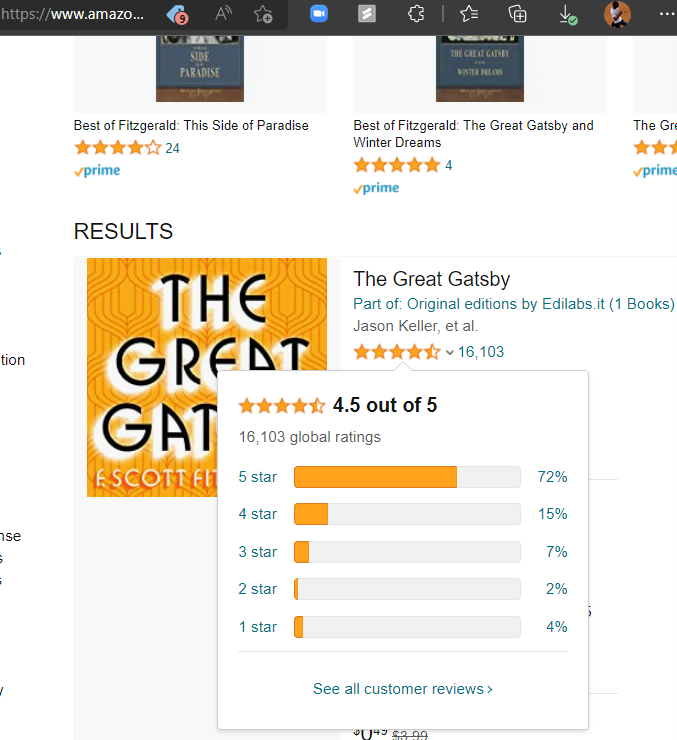

We can clearly observe that the book really has a very high rating. Image taken from Amazon.com

In [56]:
network_final_df = network_books_df.groupby(['source','destination']).size().reset_index(name='occurance')
network_final_df.head()

,source,destination,occurance
0,12,386032,1
1,33,119026,1
2,39,150250,1
3,39,412517,1
4,39,438351,1


Since it is diffcult to process such massive nodes, analyzing the predominantly dominant nodes. In this case the nodes with highest_degree (in + out) such as 199628, 458358, 430936

In [60]:
# reference - 1
nx_graph = nx.from_pandas_edgelist(
    network_final_df, 'source', 'destination', ['occurance']
)

In [62]:
num_nodes = nx_graph.number_of_nodes()
num_nodes

45889

In [63]:
num_edges = nx_graph.number_of_edges()
num_edges

92246

In [64]:
nx.is_connected(nx_graph)

False

Since we took a subset of nodes hence the graph is disconnected.

In [68]:
nx.density(nx_graph)

8.761325499135884e-05

In [70]:
num_connected_comps = nx.number_connected_components(nx_graph)
num_connected_comps

2766

# Centrality Analysis

In [73]:
dc = nx.degree_centrality(nx_graph)


In [75]:
sorted_dc = sorted(dc.items(), key=operator.itemgetter(1), reverse=True)

In [76]:
x = PrettyTable()
x.field_names = ["Attribute", "Node", "Centrality Value"]

x.add_row(["Highest Degree Centrality", sorted_dc[0][0], sorted_dc[0][1]])
print(x)

+---------------------------+--------+-----------------------+
|         Attribute         |  Node  |    Centrality Value   |
+---------------------------+--------+-----------------------+
| Highest Degree Centrality | 199628 | 0.0017869595536959553 |
+---------------------------+--------+-----------------------+


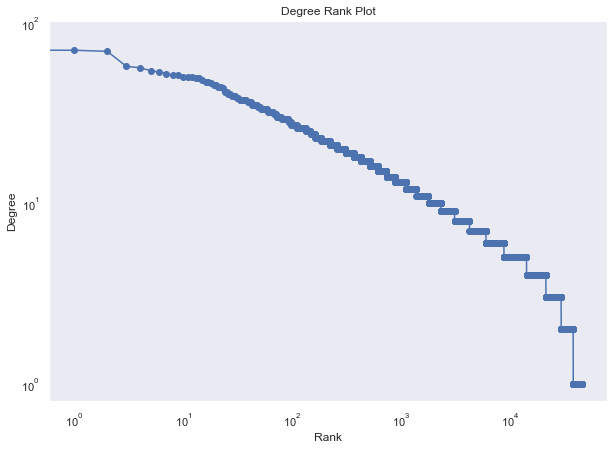

In [77]:
degree_sequence = sorted(dict(nx.degree(nx_graph)).values(), reverse=True)
plt.figure(figsize=(10,7))
plt.loglog(degree_sequence, 'b-', marker='o')
plt.title('Degree Rank Plot')
plt.ylabel('Degree')
plt.xlabel('Rank')
plt.grid()
plt.show()

Clearly Heavy tail distribution is observed in the network

In [78]:
def get_degree_distribution(graph):
    """
    Takes in a graph and returns a numpy array of node-degree distribution 
    in sorted format
    """
    d_distb = dict(nx.degree(graph))
    deg_cnt = Counter(d_distb.values())
    srtd_deg_cnt = sorted(deg_cnt.items(), key=lambda item: item[0])
    d_distb_ary = np.array(srtd_deg_cnt)
    return d_distb_ary

In [79]:
def plot_node_degree_distb(deg_distb, graph_type, symbol="#"):
    plt.figure(figsize=(10,7))
    plt.plot(deg_distb[:,0], deg_distb[:,1])
    plt.xlabel("Degree")
    plt.ylabel(f"{symbol} of Nodes having that degree")
    plt.title(f"Node-Degree distb - {graph_type}")
    plt.grid()
    plt.show()

In [80]:
degree_distb_graph = get_degree_distribution(nx_graph)

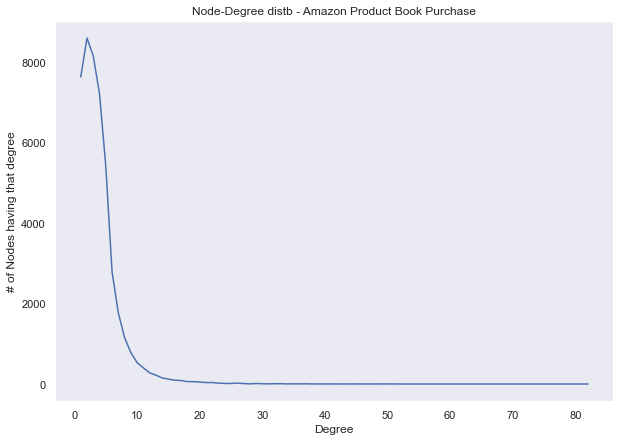

In [82]:
plot_node_degree_distb(degree_distb_graph, "Amazon Product Book Purchase")

It is evident the graph is heavytail or right skewed and following power law

In [83]:
def plot_loglog(deg_distb, graph_type, symbol="#"):
    plt.figure(figsize=(10,7))
    plt.loglog(deg_distb[:, 0], deg_distb[:, 1])
    plt.xlabel("Degree")
    plt.ylabel(f"{symbol} of Nodes having that degree")
    plt.title(f"Log-Log Plot distribution - {graph_type}")
    plt.grid()
    plt.show()

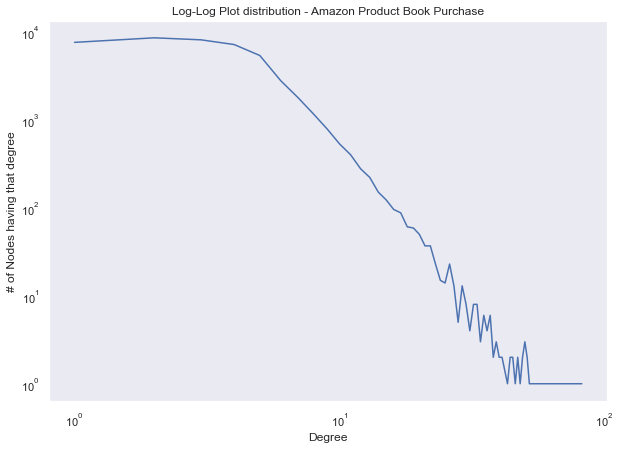

In [84]:
plot_loglog(degree_distb_graph, "Amazon Product Book Purchase")

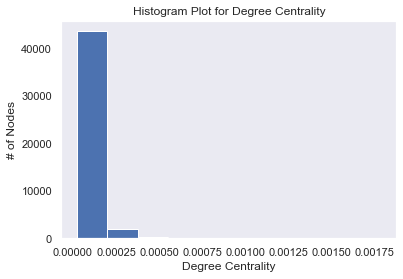

In [85]:
plt.title("Histogram Plot for Degree Centrality")
plt.xlabel("Degree Centrality")
plt.ylabel("# of Nodes")
plt.grid()
plt.hist(dc.values());

In [113]:
from matplotlib.pyplot import subplots

largest_component = nx.node_connected_component(nx_graph, 199628)

In [114]:
sub_graph = nx_graph.subgraph(largest_component)

In [ ]:
position = nx.kamada_kawai_layout(sub_graph)

In [92]:
colormap = plt.cm.get_cmap('Spectral')

node_degrees = dict(sub_graph.degree())
nodes = dict(sub_graph.nodes())
node_colors = np.asarray([node_degrees[n] for n in nodes ])
node_edges = dict(sub_graph.edges())
node_weights = [sub_graph[s][d]['occurance'] for s, d in node_edges]

In [93]:
colors = range(87)
vmin,vmax = min(colors), max(colors)

In [ ]:
picture = nx.draw_kamada_kawai(
    sub_graph,
    k = 1.2,
    with_labels = False,
    nodelist = node_degrees.keys(),
    node_size = [vertex * 30 for vertex in node_degrees.values()],
    cmap = colormap,
    width = node_weights,
    arrows = True,
    node_color = node_colors,
    vmin = vmin,
    vmax = vmax
)

In [ ]:
fig, ax = subplots()
plt.xticks(list(), list())
plt.yticks(list(), list())
flg = plt.gcf()
fig.set_size_inches(50, 50)
scalar_map = plt.cm.ScalarMappable(
    cmap = colormap,
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
)
scalar_map._A = []

colorbar = plt.colorbar(scalar_map, aspect = 40)
colorbar.ax.tick_params(labelsize = 30)
plt.figure(dpi = 1200)
plt.show()

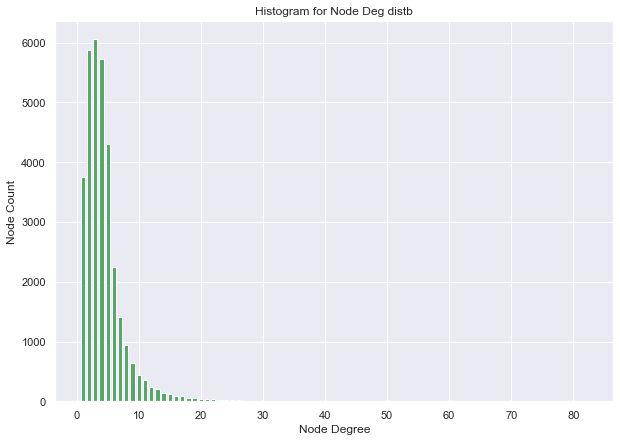

In [96]:
from bokeh.io import show, output_file
from bokeh.plotting import figure

degree_seq = [deg for nod, deg in sub_graph.degree()]
degree_seq.sort(reverse=True)

degree_count = Counter(degree_seq)

degr, count = zip(*degree_count.items())

fig, ax = plt.subplots()
plt.bar(degr, count, width=0.7, color='g')

plt.title("Histogram for Node Deg distb")
plt.ylabel("Node Count")
plt.xlabel("Node Degree")
fig = plt.gcf()
fig.set_size_inches(10,7)
plt.show()

In [97]:
sub_graph_density = nx.density(sub_graph)
sub_graph_density

0.00013324486150236413

The density is extremely small indicating the very low interconnections among the subgraph

In [98]:
sub_graph_deg_centrality = nx.degree_centrality(sub_graph)

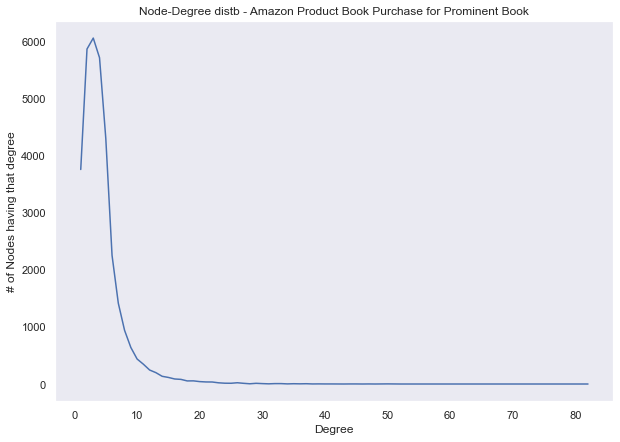

In [101]:
degree_distb_sub_graph = get_degree_distribution(sub_graph)
plot_node_degree_distb(degree_distb_sub_graph, "Amazon Product Book Purchase for Prominent Book")

In [107]:
social_dendrogram = community.generate_dendrogram(sub_graph)

In [108]:
print(f"Number of levels in the Dendrogram: {len(social_dendrogram)}")

Number of levels in the Dendrogram: 5


In [109]:
#  reference - referred the ipynb given by professor for drawing the dendrogram
def draw_dendrogram(dendrogram):
    digraph = nx.DiGraph()
    last_part = None
    
    for level_idx, part in enumerate(dendrogram):
        print(f"Level: {level_idx}, Num nodes in level: {len(part)}")
        
        for node, comunity in part.items():
            naming = f"l={level_idx}_{comunity}"
            digraph.add_node(naming, comm=comunity, color=level_idx+1)
            
            if level_idx == 0:
                digraph.add_node(node, comm=comunity, color=0)
                digraph.add_edge(naming, node)
            else:
                digraph.add_edge(naming, f"l={level_idx-1}_{node}")
        last_part = part
        
    plt.figure(figsize=(15, 10))
    
    colors = list(nx.get_node_attributes(digraph, "color").values())
    
    layout = graphviz_layout(digraph, prog="dot")
    nx.draw(digraph, layout, with_labels=True, arrows=False, node_color=colors,
           vmin=0, vmax=len(dendrogram)+1, cmap=plt.cm.tab20)

# References

1. How to read edges from network nx https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html